In [2]:
import os
import tempfile

import numpy as np
import requests
import scanpy as sc
import scvi
import seaborn as sns
import torch

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.6


# Import Data

In [25]:
adata = sc.read("/data/rudensky/EYW/SIG04_240816/python_outs/SIG04_merge_singlets_SCT_scanpy.h5ad")

In [48]:
adata = adata[:, adata.var["highly_variable"]].copy()

For reference, plot the UMAP of perturbed cells based on pearson residuals

/home/wange7/miniforge3/envs/scvi-gpu/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


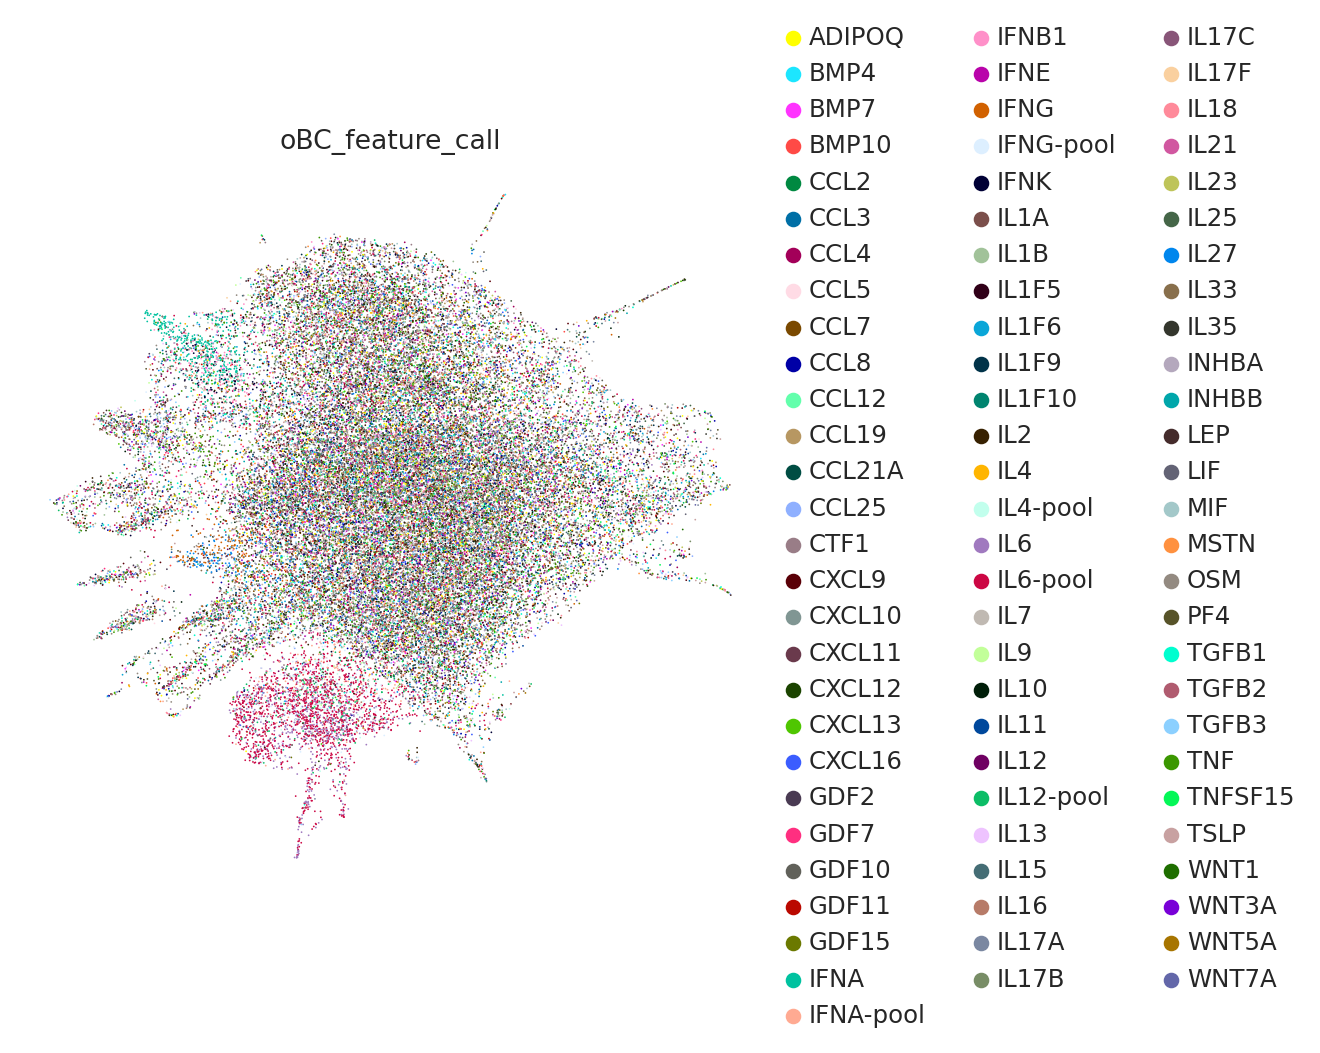

In [52]:
perturbed_adata = adata[adata.obs["oBC_feature_call"] != "p129"]  # Only consider perturbed cells

sc.pp.pca(perturbed_adata)
sc.pp.neighbors(perturbed_adata)
sc.tl.umap(perturbed_adata)
sc.pl.umap(perturbed_adata, color=["oBC_feature_call"])

# Run Model

In [49]:
# set up model anndata (including covariates)
scvi.external.ContrastiveVI.setup_anndata(adata,
                                          layer="counts")

# set up model
contrastive_vi_model = scvi.external.ContrastiveVI(
    adata, n_salient_latent=10, n_background_latent=10, use_observed_lib_size=False
)

# setup control and perturbed indices
background_indices = np.where(adata.obs["oBC_feature_call"] == "p129")[0]
target_indices = np.where(adata.obs["oBC_feature_call"] != "p129")[0]

In [50]:
contrastive_vi_model.train(
    background_indices=background_indices,
    target_indices=target_indices,
    early_stopping=True,
    max_epochs=500
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wange7/miniforge3/envs/scvi-gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/wange7/miniforge3/envs/scvi-gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 384/500:  77%|███████▋  | 384/500 [1:01:28<18:34,  9.61s/it, v_num=1, train_loss_step=5.28e+3, train_loss_epoch=5.26e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 5294.490. Signaling Trainer to stop.


In [53]:
perturbed_adata.obsm["salient_rep"] = contrastive_vi_model.get_latent_representation(
    perturbed_adata, representation_kind="salient"
)

perturbed_adata.obsm["background_rep"] = contrastive_vi_model.get_latent_representation(
    perturbed_adata, representation_kind="background"
)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [54]:
sc.pp.neighbors(perturbed_adata, use_rep="salient_rep")
sc.tl.umap(perturbed_adata)

In [55]:
perturbed_adata.X = perturbed_adata.layers['log1p_norm'].copy()

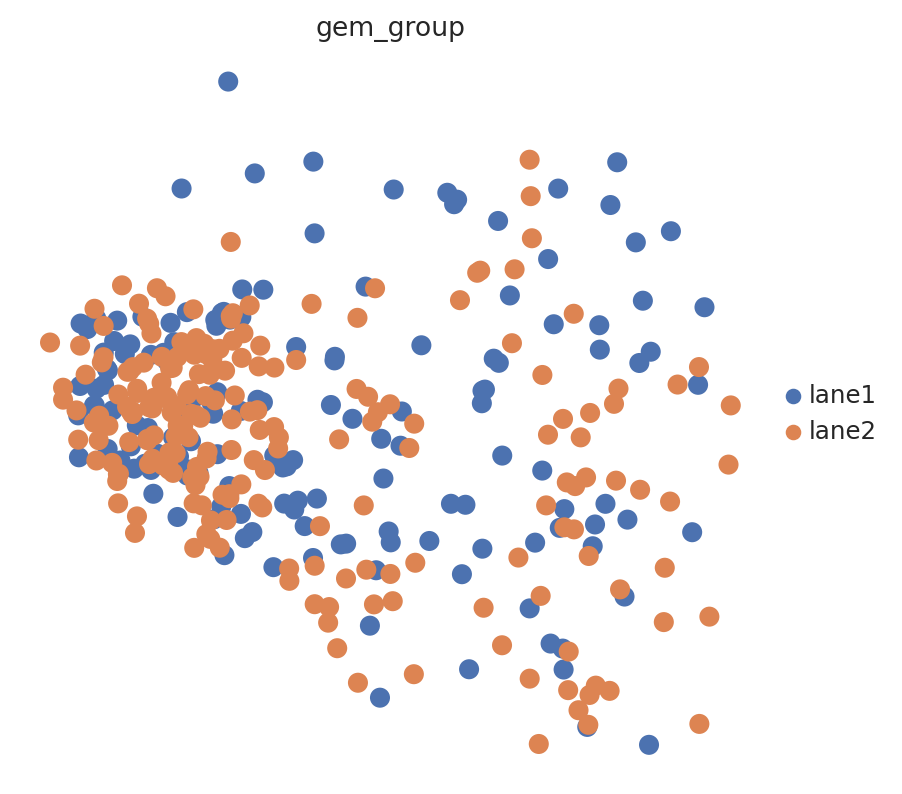

In [71]:
sc.pl.umap(perturbed_adata[perturbed_adata.obs["oBC_feature_call"] == "IL4-pool"], color=["gem_group"])

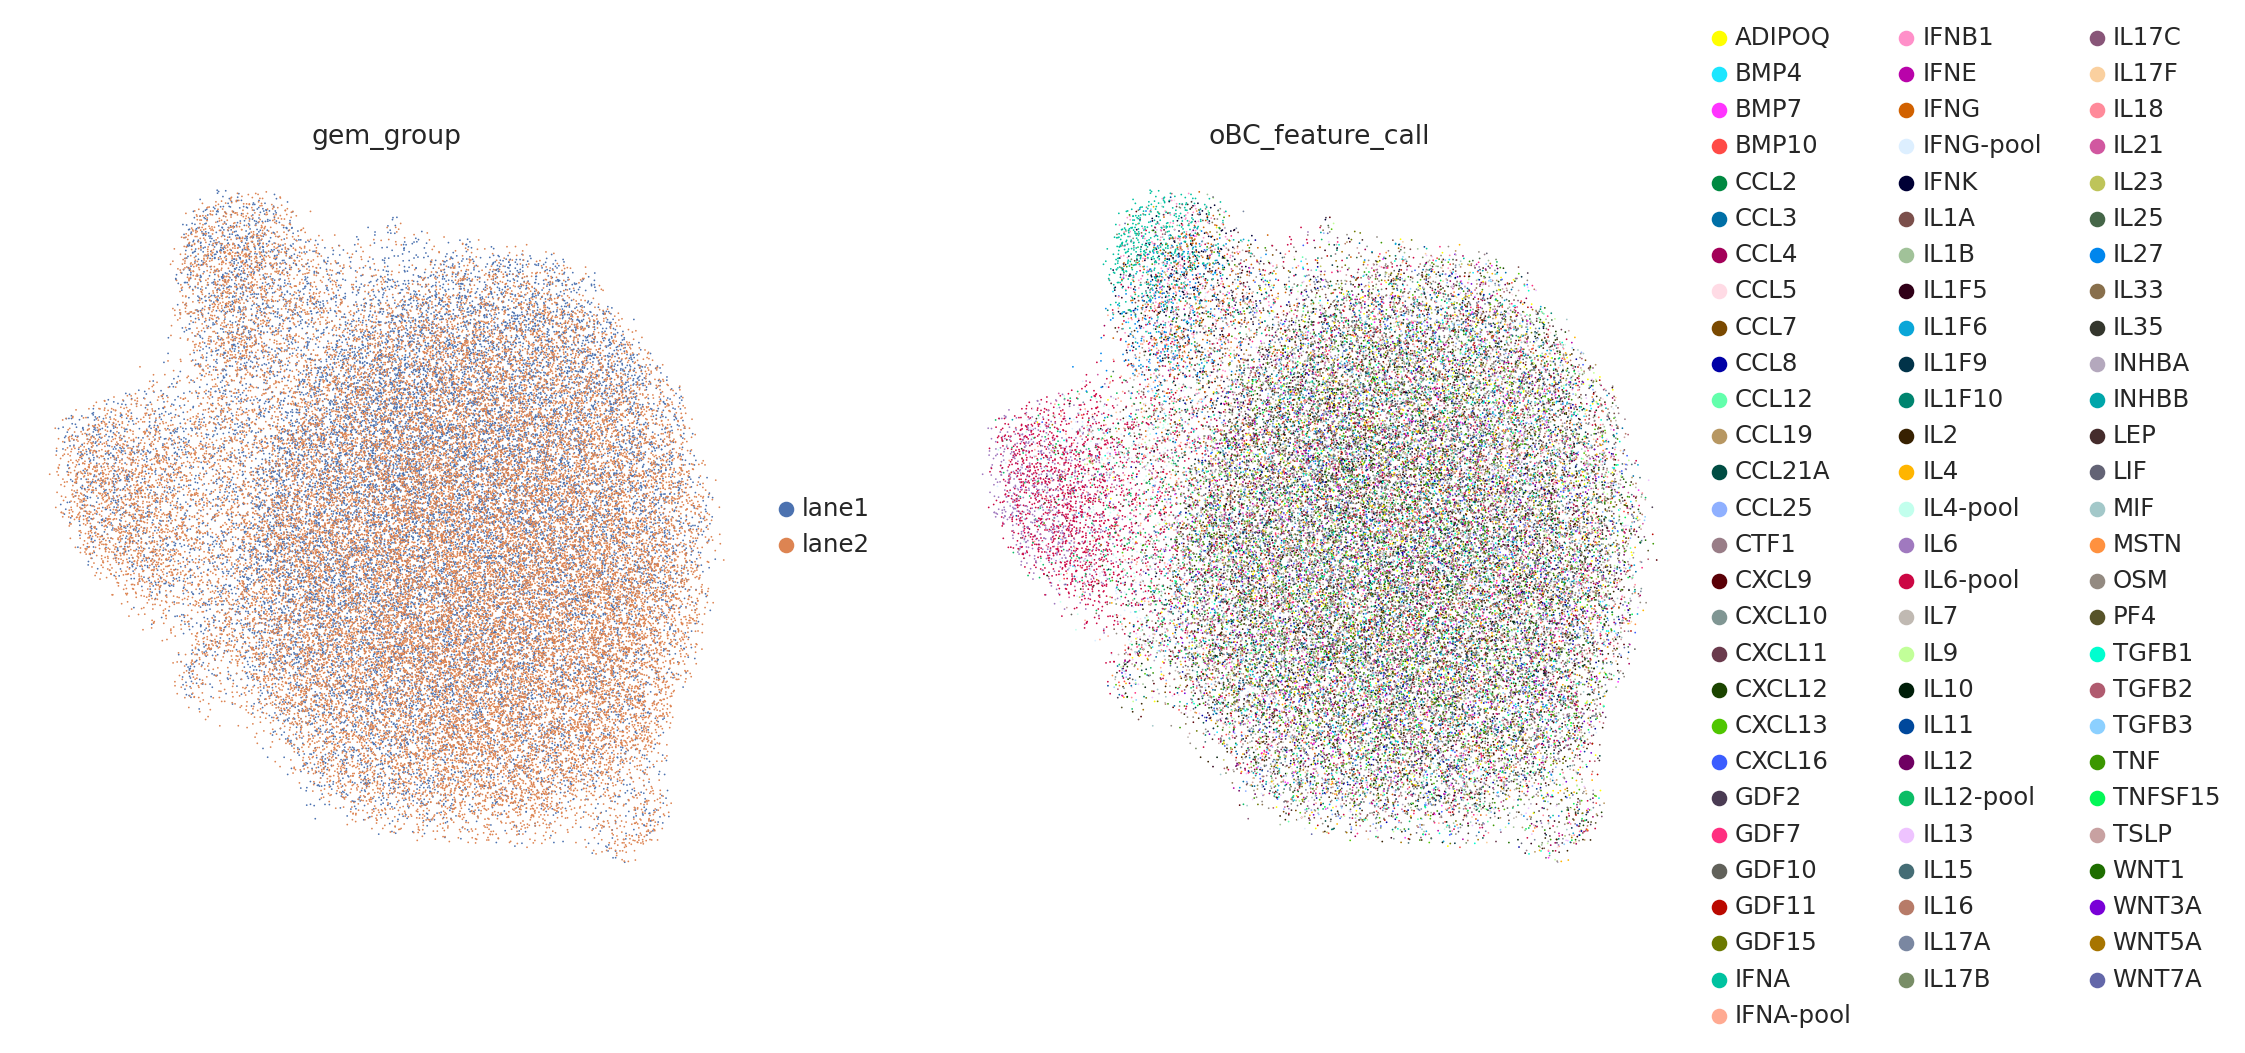

In [58]:
sc.pl.umap(perturbed_adata, color=["gem_group",'oBC_feature_call'])